<a href="https://colab.research.google.com/github/vianelk/ax-metrics/blob/train_model/ax_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# Download dataset

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumithsingh/blood-cell-images-for-cancer-detection")

print("Path to dataset files:", path)

100%|██████████| 122M/122M [00:01<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2


In [24]:
DATASET_PATH = './kaggle/input/blood-cell-images-for-cancer-detection'

In [26]:
!mkdir -p {DATASET_PATH}

!cp -r {path}/* {DATASET_PATH}/

# Setup Project Config

Set random seed

In [30]:
SEED = 42
np.random.seed(SEED)

List classes

In [28]:
CLASSES = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']

Define image size

In [29]:
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Data Preprocessing

## Quick Exploration

View number of images per class

In [31]:
for class_name in CLASSES:
    print(f"{class_name}: {len(os.listdir(os.path.join(DATASET_PATH, class_name)))} images")

basophil: 1000 images
erythroblast: 1000 images
monocyte: 1000 images
myeloblast: 1000 images
seg_neutrophil: 1000 images


Load data

In [45]:
images = []
labels = []

In [46]:
any_corrupted_files = False

for class_index, class_name in enumerate(CLASSES):
    folder_path = os.path.join(DATASET_PATH, class_name)
    for img_file in os.listdir(folder_path):
        try:
            img = cv2.imread(os.path.join(folder_path, img_file))
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            images.append(img)
            labels.append(class_index)
        except:
            any_corrupted_files = True
            print(f"Corrupt file: {img_file}")

if not any_corrupted_files:
    print("No corrupted files")

images = np.array(images)
labels = np.array(labels)

No corrupted files


Normalize images

array([[[169, 162, 197],
        [171, 162, 202],
        [176, 166, 208],
        ...,
        [176, 189, 224],
        [189, 218, 241],
        [192, 222, 247]],

       [[180, 171, 209],
        [182, 189, 219],
        [191, 211, 233],
        ...,
        [182, 196, 231],
        [192, 221, 244],
        [191, 221, 246]],

       [[195, 222, 239],
        [198, 230, 250],
        [194, 230, 254],
        ...,
        [179, 192, 227],
        [191, 220, 243],
        [192, 222, 247]],

       ...,

       [[203, 229, 253],
        [203, 229, 253],
        [203, 229, 253],
        ...,
        [170, 181, 214],
        [177, 188, 220],
        [171, 183, 215]],

       [[204, 230, 254],
        [203, 229, 253],
        [202, 228, 252],
        ...,
        [184, 219, 240],
        [187, 218, 244],
        [187, 211, 242]],

       [[196, 232, 255],
        [199, 231, 255],
        [201, 231, 255],
        ...,
        [192, 215, 247],
        [190, 214, 244],
        [188, 212, 240]]], dtype=uint8)
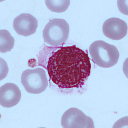

In [47]:
images[0]

In [48]:
images = images / 255.0

In [49]:
images[0]

array([[[0.6627451 , 0.63529412, 0.77254902],
        [0.67058824, 0.63529412, 0.79215686],
        [0.69019608, 0.65098039, 0.81568627],
        ...,
        [0.69019608, 0.74117647, 0.87843137],
        [0.74117647, 0.85490196, 0.94509804],
        [0.75294118, 0.87058824, 0.96862745]],

       [[0.70588235, 0.67058824, 0.81960784],
        [0.71372549, 0.74117647, 0.85882353],
        [0.74901961, 0.82745098, 0.91372549],
        ...,
        [0.71372549, 0.76862745, 0.90588235],
        [0.75294118, 0.86666667, 0.95686275],
        [0.74901961, 0.86666667, 0.96470588]],

       [[0.76470588, 0.87058824, 0.9372549 ],
        [0.77647059, 0.90196078, 0.98039216],
        [0.76078431, 0.90196078, 0.99607843],
        ...,
        [0.70196078, 0.75294118, 0.89019608],
        [0.74901961, 0.8627451 , 0.95294118],
        [0.75294118, 0.87058824, 0.96862745]],

       ...,

       [[0.79607843, 0.89803922, 0.99215686],
        [0.79607843, 0.89803922, 0.99215686],
        [0.79607843, 0

Convert labels to categorical format

In [50]:
labels[:5]

array([0, 0, 0, 0, 0])

In [51]:
labels = to_categorical(labels, num_classes=len(CLASSES))

In [52]:
labels[:5]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

# Model Training

Split data in train, validation and test sets

In [54]:
# 30% of data for validation and test, the remaining 70% for training

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=SEED)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED)

Create model

In [55]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile model with optimizer and loss function

In [56]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Display model summary

In [57]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,213 (24.87 MB)

 Trainable params: 6,517,765 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

Train model

In [58]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=20,
    steps_per_epoch=len(X_train) // 32
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7685 - loss: 1.8440 - val_accuracy: 0.1973 - val_loss: 20.7444
Epoch 2/20
  1/109 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.7500 - loss: 1.3050

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.7500 - loss: 1.3050 - val_accuracy: 0.1973 - val_loss: 20.0104
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9140 - loss: 0.3362 - val_accuracy: 0.1973 - val_loss: 24.3340
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 1.0000 - loss: 0.0501 - val_accuracy: 0.1973 - val_loss: 23.9128
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9506 - loss: 0.2104 - val_accuracy: 0.1973 - val_loss: 25.8885
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 1.0000 - loss: 0.0327 - val_accuracy: 0.1973 - val_loss: 24.8746
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9540 - loss: 0.1826 - val_accuracy: 0.3133 - val_loss: 16.0448
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.3120 - val_loss: 16.8595
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9715 - loss: 0.0966 - val_accur

History plot

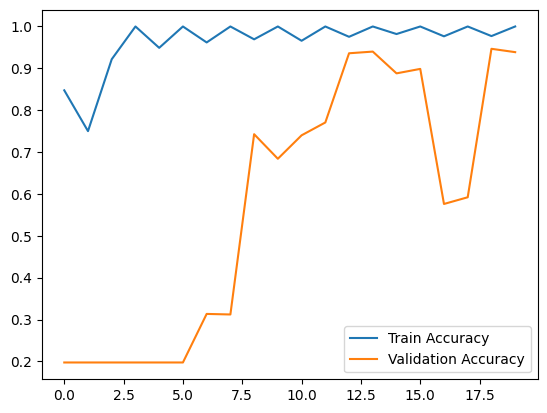

In [59]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

Make a prediction on a single input

In [68]:
y_test[:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [74]:
image_index = 1

In [75]:
pred = model.predict(np.expand_dims(X_test[image_index], axis=0))

pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


array([[1.1591231e-03, 1.9739515e-01, 8.0110496e-01, 3.4075347e-04,
        2.2557817e-10]], dtype=float32)

In [76]:
pred_class_index = np.argmax(pred[0])
actual_class_index = np.argmax(y_test[image_index])

print(f"Predicted: {pred_class_index} - {CLASSES[pred_class_index]}")
print(f"Actual: {actual_class_index} - {CLASSES[actual_class_index]}")

Predicted: 2 - monocyte
Actual: 2 - monocyte
